In [1]:
import os
import json
import boto3

path = 's3://dog-breed-v2/train/'
# def get_labels_dict(path):
#     labels_dict = {}
#     for folder_name in os.listdir(path):
#         if os.path.isdir(os.path.join(path, folder_name)):
#             # Split on the first dot
#             number, name = folder_name.split('.', 1)
#             labels_dict[int(number)] = name
#     return labels_dict

def get_labels_dict(bucket_name, prefix):
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix, Delimiter='/')

    labels_dict = {}
    for page in pages:
        for obj in page.get('CommonPrefixes', []):
            folder_name = obj['Prefix'].split('/')[-2]  # gets the last folder name before the slash
            number, name = folder_name.split('.', 1)
            labels_dict[int(number)] = name
    return labels_dict


bucket = 'dog-breed-v2'
prefix = 'train/'  # make sure this ends with a slash

labels_dict = get_labels_dict(bucket, prefix)

# show first 10 labels
{k: v for k, v in labels_dict.items() if k < 10}

{1: 'Affenpinscher',
 2: 'Afghan_hound',
 3: 'Airedale_terrier',
 4: 'Akita',
 5: 'Alaskan_malamute',
 6: 'American_eskimo_dog',
 7: 'American_foxhound',
 8: 'American_staffordshire_terrier',
 9: 'American_water_spaniel'}

In [2]:
with open("./scripts/labels.json", "w") as f:
    json.dump(labels_dict, f)

In [3]:
import sagemaker
from sagemaker.pytorch import PyTorch as PyTorchEstimator
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
import boto3

session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 paths
bucket = 'dog-breed-v2'
code_location = f's3://{bucket}/code'
model_output = f's3://{bucket}/outputs/'

# Launch training job
estimator = PyTorchEstimator(
    entry_point='train.py',
    source_dir='scripts',
    role=role,
    framework_version='1.13',
    py_version='py39',
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=model_output,
    hyperparameters={
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 5,
    },
    base_job_name='dog-breed-train-job',
    use_spot_instances=True,
    max_wait=3600,
    max_run=1800
)


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/24/25 19:05:28] INFO     Found credentials from IAM Role:                                   ]8;id=104507;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=686016;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
# invokes: /opt/conda/bin/python3.9 train.py --batch_size 32 --epochs 5 --learning_rate 0.001
estimator.fit({'training': f's3://{bucket}/'})


[04/24/25 19:05:29] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=531737;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=870912;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=795479;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=657293;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=911886;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=163915;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             dog-breed-train-job-2025-04-24-19-05-29-485                                           

2025-04-24 19:05:34 Starting - Starting the training job...
2025-04-24 19:05:59 Starting - Preparing the instances for training...
2025-04-24 19:06:32 Downloading - Downloading input data.........
2025-04-24 19:07:37 Downloading - Downloading the training image...............
2025-04-24 19:10:12 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES

In [5]:
estimator.model_data

's3://dog-breed-v2/outputs/dog-breed-train-job-2025-04-24-19-05-29-485/output/model.tar.gz'

In [6]:
# download the model data
!aws s3 cp {estimator.model_data} .


download: s3://dog-breed-v2/outputs/dog-breed-train-job-2025-04-24-19-05-29-485/output/model.tar.gz to ./model.tar.gz


In [7]:
# unzip & save the model.pth in model_artifacts
!mkdir -p model_artifacts
!tar -xvzf model.tar.gz -C model_artifacts


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model.pth


In [8]:
# !rm -rf model_artifacts

In [9]:
estimator.training_image_uri()

[04/24/25 19:14:23] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=81144;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=91662;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

'763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.13-gpu-py39'

In [10]:
import boto3

model_uri = estimator.model_data
bucket_name = model_uri.split('/')[2]
key = '/'.join(model_uri.split('/')[3:])

print(f'b {bucket_name} -- k {key}')

s3 = boto3.client('s3')
try:
    s3.head_object(Bucket=bucket_name, Key=key)
    print("✅ Model artifact exists.")
except s3.exceptions.ClientError as e:
    print("❌ Model not found in S3:", e.response['Error']['Message'])


b dog-breed-v2 -- k outputs/dog-breed-train-job-2025-04-24-19-05-29-485/output/model.tar.gz
✅ Model artifact exists.


In [11]:
from sagemaker.pytorch import PyTorchModel

inference_model = PyTorchModel(
    model_data=estimator.model_data,
    role=role,
    entry_point='inference.py',
    source_dir='scripts',
    framework_version='1.13',
    py_version='py39',
    sagemaker_session=session
)


In [12]:
predictor = inference_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='dog-breed-endpoint-x2'
)


                    INFO     Repacking model artifact                                                  ]8;id=895856;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=705430;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/model.py#820\820]8;;\
                             (s3://dog-breed-v2/outputs/dog-breed-train-job-2025-04-24-19-05-29-485/ou             
                             tput/model.tar.gz), script artifact (scripts), and dependencies ([]) into             
                             single tar.gz file located at                                                         
                             s3://sagemaker-us-east-1-370418385289/pytorch-inference-2025-04-24-19-14-             
                             23-606/model.tar.gz. This may take some time depending on model size...               

[04/24/25 19:14:25] INFO     Creating model with name: pytorch-inference-2025-04-24-19-14-25-780    ]8;id=287281;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=562315;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/24/25 19:14:26] INFO     Creating endpoint-config with name dog-breed-endpoint-x2               ]8;id=398776;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=523107;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\

                    INFO     Creating endpoint with name dog-breed-endpoint-x2                      ]8;id=237297;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=614872;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

---------------!

In [13]:
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()


In [14]:
img_path = 'https://upload.wikimedia.org/wikipedia/commons/b/bf/Bulldog_inglese.jpg'
payload = {"image_url": img_path}
response = predictor.predict(payload)
print(response)  # {'label': 12, 'class_name': 'beagle'}


{'label': 39, 'class_name': 'Bull_terrier'}


In [24]:
# img_path = './lab.jpg'
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Afra_013.jpg/1280px-Afra_013.jpg'
payload = {"image_url": img_path}
response = predictor.predict(payload)
print(response)  # {'label': 12, 'class_name': 'beagle'}


{'label': 26, 'class_name': 'Black_russian_terrier'}


In [15]:
# predictor.delete_endpoint()

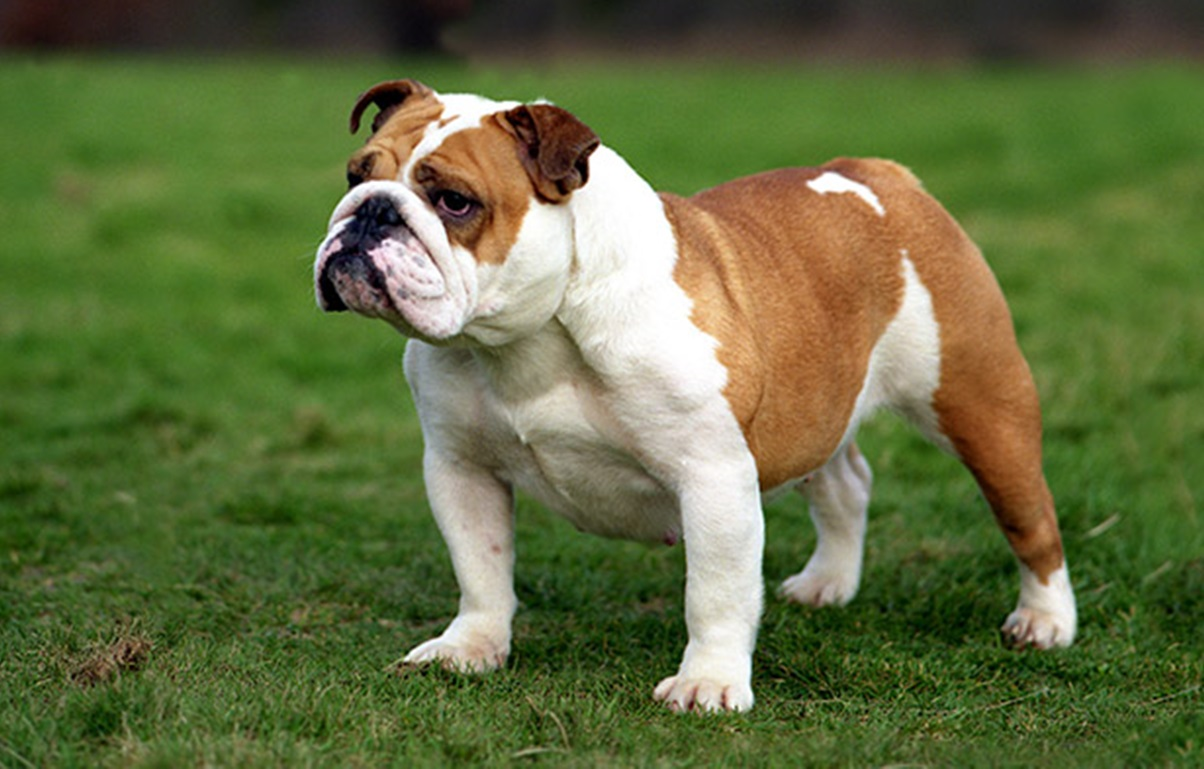

In [21]:
from PIL import Image
import requests
from io import BytesIO

img_url = 'https://upload.wikimedia.org/wikipedia/commons/b/bf/Bulldog_inglese.jpg'

response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img.show()  # this opens it in a preview tab if running locally; for notebooks, use display()

# # For SageMaker/Jupyter display inline
# from IPython.display import display
# display(img)


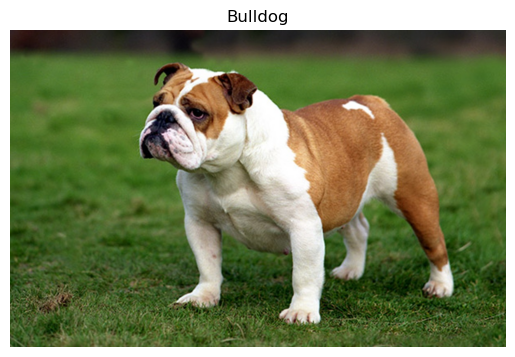

In [22]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title("Bulldog")
plt.show()
